# Cryosphere model Comparison tool (CmCt) --- Gravimetry

The CmCt GRACE mascon tool compares user uploaded ice sheet model to satellite gravimetry in the form of mascon data, derived from the GRACE and GRACE-FO satellite missions. The CmCt reprojects modeled ice sheet mass change into mascon space and performs a direct quantitative comparison, calculating model-observation discrepancies, therefore bringing the ice sheet model and gravimetry data to the same spatial resolution for comparison. 

## Mascon dataset description

For comparison to the user's model, the tool currently uses the `GSFC.glb.200204_202312_RL06v2.0_OBP-ICE6GD` GRACE mascon product from 04/2002 to 12/2023 that can be requested at the NASA GSFC dataset [main distribution site](https://earth.gsfc.nasa.gov/geo/data/grace-mascons/). Future developments will include adding the functionality to automatically check the product distribution website for an updated dataset.

## Input data requirements

The input ice sheet model needs to be provided as a netCDF file. The user may upload a single input file that includes multiple years; future enhancements to this tool will allow users to upload model ensembles.

There are several requirements for the comparison:

### `Lithk` variable

The CmCt Grace Mascon tool expects the uploaded model to contain thickness data (the `lithk` variable) for the comparison.

### Rectangular grid

At time of writing, models *must* be defined on a rectangular X-Y grid in the ISMIP6 standard projected polar-stereographic space. (Note, NOT a lat-lon grid!) The ISMIP6 standard projection is defined [here](https://theghub.org/groups/ismip6/wiki). 

### Date range

The gravimetry data spans 04/2002 to 12/2023. The user can select start and end dates within this span as part of the setup for the tool.

## Using this tool

This tool can be run in Jupyter [Appmode](https://github.com/oschuett/appmode) on systems that support this feature (e.g., Ghub). The user interface buttons enable upload, plotting, and download.
1. Upload model data for comparison using the `Upload File` button.
1. Select the desired start and end times for comparison.
1. Run comparison and generate output plot using the `Plot Data` button.


## Tool output

from gravimetry_utils import *This tool creates a plot that GRACE mascon plot and the model mascon plot so the user can  qualitatively compare the model output with the observational data. 

---

In [11]:
## Import modules
import os,sys
import glob as glob
import numpy as np
import h5py
import xarray as xr
import glob as glob

import datetime

# # Add the directory containing 'mascons.py' to the Python path
# sys.path.append(os.path.abspath('/home/jovyan/CmCt/bin/Gravimetry'))
# import mascons

# Add the directory containing 'mascons.py' to the Python path
# Get the current working directory
current_directory = os.getcwd()
# Navigate two levels up to reach main dir
parent_directory = os.path.abspath(os.path.join(current_directory, os.pardir, os.pardir))
# Insert the specific directory into the system path
sys.path.insert(0, os.path.join(parent_directory, 'bin', 'Gravimetry'))
# Now import mascons
import mascons

from gravimetry_utils import *

# As of July 2024 tested with the Jupyter on Deb10 tool and the Python 3 Kernel.
# This notebook is also opened outside of the Ghub environment where the geospatial-plus python3 Kernel is not available, so,
# need to use the Python 3 Kernel.
# hublib.use and %use geospatial-2021-09 will not work outside of the Ghub environment, so,
# need to explicitly add the geospatial-plus python3 Kernel's environment's site-packages to PYTHONPATH.
site_packages = '/apps/share64/debian10/anaconda/anaconda-7/envs/geospatial-2021-09/lib/python3.7/site-packages'
if os.path.exists(site_packages):
    sys.path.append(site_packages)

import cartopy
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader

import matplotlib.pyplot as plt
from matplotlib import rc
rc('mathtext', default='regular')

sys.path.insert(0, os.path.abspath('..'))

import ipywidgets as widgets
from IPython.display import display,clear_output,HTML
import PIL.Image # Python Image Library
from ipywidgets import DatePicker, Layout, VBox, Button, Output

import importlib.util  
sys.path.insert(0, os.path.abspath('..'))
# Check if the 'hublib.ui' module is available
if importlib.util.find_spec("hublib") is not None:
    from hublib.ui import FileUpload, Download
    system_flag = 'ghub'
else:
    system_flag = 'local'

# note: suppress numpy.dtype size changed warnings
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")

warnings.filterwarnings('ignore')

## Set polar sterographic projection definition
Currently, the CmCt expects the model data to be provided in a specific polar stereographic projection. This is hardcoded in the notebook. As a future enhancement, the projection can be obtained from the loaded model.

### Set time range for comparison

In [9]:
# Run in Ghub
if system_flag == 'ghub':
#  User interface elements
    
    #Load Mascons data dir
    Mascon_data_path=os.path.expanduser('/data/groups/ghub/tools/cmct/')

    ## USER INTERFACE
    
    #Set Time Range for Comparison(start and end dates for model/observation comparison)    
    # Create date pickers for start and end dates
    start_date_picker = DatePicker(description='Start Date', disabled=False, layout=Layout(width='350px'), value = datetime.date(2002,4,1))
    end_date_picker = DatePicker(description='End Date', disabled=False, layout=Layout(width='350px'), value = datetime.date(2023,12,31))
    start_date = '2005-01-01' # 'YYYY-MM-DD'
    end_date = '2014-12-31' # 'YYYY-MM-DD'
    
    # Create a button to confirm the selected dates
    confirm_button = Button(description='Confirm Dates', button_style='success', layout=Layout(width='350px'))
    output_widget = Output()
    
    # Define the callback function for the confirm button
    def confirm_dates(b):
        global start_date, end_date
        with output_widget:
            output_widget.clear_output()
            start_date = start_date_picker.value.strftime('%Y-%m-%d')
            end_date = end_date_picker.value.strftime('%Y-%m-%d')
            print(f'Start Date: {start_date}')
            print(f'End Date: {end_date}')
     
    # Bind the confirm button to the callback function
    confirm_button.on_click(confirm_dates)
    
    # Display the date pickers and the confirm button
    display(VBox([start_date_picker, end_date_picker, confirm_button, output_widget]))  

# For Cryocloud 
if system_flag == 'local':
    # start and end dates for model/observation comparison
    start_date = '2005-01-01' # 'YYYY-MM-DD'
    end_date = '2014-12-31' # 'YYYY-MM-DD'
    
    #Model data path
    nc_file_name='/home/jovyan/shared-public/CmCt/models/lithk_GIS_IMAU_IMAUICE1_historical.nc'
    #Mascons data path
    Mascon_data_path_dir=os.path.expanduser('/home/jovyan/shared-public/CmCt/gravimetry_code/')

## Upload ice sheet model

Plotting Data [--------------------] 0.0%
Plotting Data [##------------------] 10.0%
Plotting Data [####----------------] 20.0%
Plotting Data [######--------------] 30.0%
Plotting Data [############--------] 60.0%
Plotting Data [################----] 80.0%


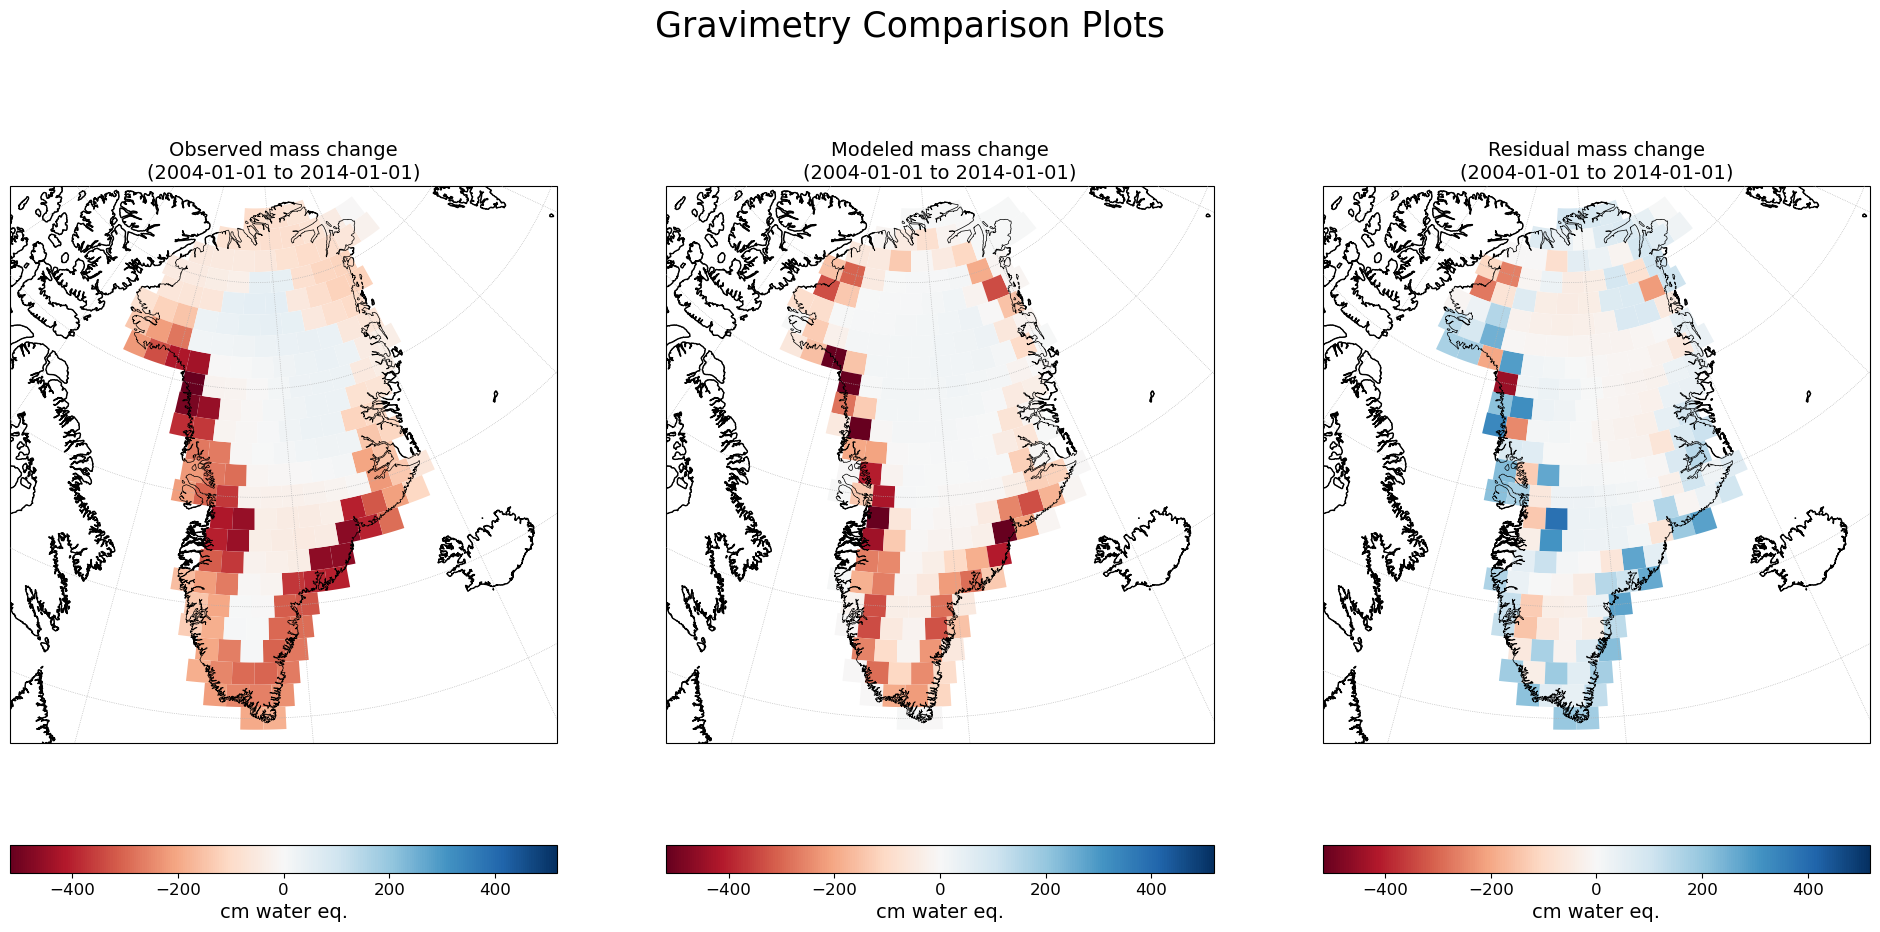

In [10]:
# Run in Ghub
if system_flag == 'ghub':

    # Called when all files finish uploading
    def done_cb(w, name):
        # output_widget.clear_output()
        # with output_widget:
        print("%s uploaded" % name[0])
        global file_name
        file_name = name[0]
        uploaded_data.layout.visibility = 'visible'
        uploaded_data.disabled = False
        # reset clears and re-enables the widget for more uploads
        w.reset()
    
    # Called on click of Plot Data button:
    # run the processing then plot the uploaded data
    def uploaded_cb(b):
        uploaded_data.disabled = True
        f.visible = False    
        status = runProcessing(Mascon_data_path,file_name,system_flag,start_date,end_date,output_widget)    
        #if status != 'Failed':
        if status is  None:
            uploaded_data.disabled = True
        f.visible = True
    
    #CMCT File Upload
    # Plot button for uploaded data
    uploaded_data = widgets.Button(
    description = 'Plot Data',
    button_style = 'info',
    layout = widgets.Layout(visibility = 'hidden'))
    # tie the event handler to the button:
    uploaded_data.on_click(uploaded_cb)
    
    output_widget = widgets.Output()
    
    # Upload button for input data
    global upload_directory
    upload_directory = 'data'
    f = FileUpload('',
     'Please Upload Your File',
    dir=upload_directory,
    cb=done_cb,
    maxsize='150M',
    width = '350px')

    # display plots
    display(output_widget)
       
    # Display file upload widget
    display(f)
    
    # Display plotting button for uploaded data
    display(uploaded_data)

# Run in Cryocloud
else:
    
    # Process
    file_name=nc_file_name
    runProcessing(Mascon_data_path_dir,file_name,system_flag,start_date,end_date)